This uses both GEI and Skeleton Data in Ensemble Models to Classify person from their gait

In [ ]:
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/silhouette_vids /content/sil
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/pose /content/pose

In [ ]:
import os
import json
import numpy as np

# Initialize an empty list to store the pose data arrays
pose_data_dict = {}

# Define the path to the main directory
main_dir = '/content/pose'

# Traverse through all the subdirectories in the main directory
for sub_dir in os.listdir(main_dir):
    json_path = os.path.join(main_dir, sub_dir, 'json')

    # Check if the json_path exists and is a directory
    if os.path.isdir(json_path):
        pose_sub_list = []
        for json_file in os.listdir(json_path):
            file_path = os.path.join(json_path, json_file)

            # Read the JSON file and extract the pose data
            with open(file_path, 'r') as f:
                pose_data = json.load(f)

                # Convert the pose data to a NumPy array and append it to the list
                pose_data_array = np.array(pose_data)
                pose_sub_list.append(pose_data_array)
        pose_sub_array = np.concatenate(pose_sub_list,axis=0)
        pose_data_dict[sub_dir] = pose_sub_array

# Output the shape of the stacked array to verify
print(f'Stacked Pose Data Shape: {len(pose_data_dict)}')

Stacked Pose Data Shape: 25


In [ ]:
import os
import numpy as np
import cv2

def video_to_array(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Get video properties
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create an empty array to store frames
    video_array = np.zeros((num_frames, height, width), dtype=np.uint8)

    # Read and store frames
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Store frame in the array
        video_array[frame_idx, :, :] = gray_frame
        frame_idx += 1

    cap.release()

    return video_array

# Initialize an empty list to store the pose data arrays
vid_data_dict = {}

# Define the path to the main directory
main_dir = '/content/sil'

# Traverse through all the subdirectories in the main directory
for sub_dir in os.listdir(main_dir):
    vid_folder_path = os.path.join(main_dir, sub_dir)
    # Check if the json_path exists and is a directory
    if os.path.isdir(vid_folder_path):
      for file_name in os.listdir(vid_folder_path):
          video_path = os.path.join(vid_folder_path, file_name)
          video_array = video_to_array(video_path)
          if video_array is not None:
              vid_data_dict[sub_dir] = video_array
# Output the shape of the stacked array to verify
print(f'Stacked vid Data Shape: {len(vid_data_dict)}')

Stacked vid Data Shape: 25


In [ ]:
print(vid_data_dict["Sub0"].shape)
print(pose_data_dict["Sub0"].shape)

(230, 500, 500)
(230, 25, 3)


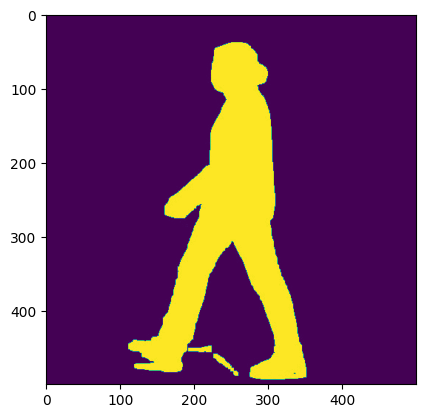

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(vid_data_dict["Sub0"][20])
plt.show()

filter data set

In [ ]:
filtered_vid_dict = {}
filtered_pose_dict = {}
minimum_num_frames = 230
labelCounter = 0
for key in vid_data_dict:
  if (vid_data_dict[key].shape[0]>=minimum_num_frames):
    filtered_vid_dict[labelCounter] = vid_data_dict[key]
    filtered_pose_dict[labelCounter] = pose_data_dict[key]
    labelCounter+=1

Distinct Samples

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize lists to store features (X) and labels (Y)
X_pose = []
X_GEI = []
Y = []

# Iterate over each class in the pose_data_list
for class_label in filtered_pose_dict:
    pose_array = filtered_pose_dict[class_label]
    vid_array = filtered_vid_dict[class_label]
    num_slices = pose_array.shape[0] // 23  # Total slices of size (23, 25, 3)

    for i in range(num_slices):
        # Extract a slice of size (23, 25, 3) from the first dimension
        start_slice = i*23
        slice_23 = pose_array[start_slice:start_slice+23, :, :]
        GEI = vid_array[start_slice:start_slice+23, :, :].mean(axis = 0,keepdims=True)
        # Append the slice to X and the label to Y
        X_pose.append(slice_23)
        X_GEI.append(GEI)
        Y.append(class_label)

# Convert X and Y lists to NumPy arrays for further processing
X_pose = np.array(X_pose)
X_GEI = np.array(X_GEI)
Y = np.array(Y)

indices = range(len(Y))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42,stratify=Y)
Y_train, Y_test = Y[train_indices], Y[test_indices]
X_train_pose = X_pose[train_indices]
X_train_GEI = X_GEI[train_indices]

X_test_pose = X_pose[test_indices]
X_test_GEI = X_GEI[test_indices]

# Output the shapes of the training and testing sets to verify
print(f'Training Pose Features Shape: {X_train_pose.shape}')
print(f'Training GEI Features Shape: {X_train_GEI.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Pose Features Shape: {X_test_pose.shape}')
print(f'Testing GEI Features Shape: {X_test_GEI.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Pose Features Shape: (361, 23, 25, 3)
Training GEI Features Shape: (361, 1, 500, 500)
Training Labels Shape: (361,)
Testing Pose Features Shape: (91, 23, 25, 3)
Testing GEI Features Shape: (91, 1, 500, 500)
Testing Labels Shape: (91,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le_ = LabelEncoder()
le_.fit(Y_train)
transformed_y = le_.transform(Y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_Pose = RandomForestClassifier(n_estimators = 100)
model_Pose.fit(X_train_pose.reshape(X_train_pose.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_GEI = RandomForestClassifier(n_estimators = 100)
model_GEI.fit(X_train_GEI.reshape(X_train_GEI.shape[0],-1), Y_train)

RandomForestClassifier()

Individual Performance

In [ ]:
y_pred = model_Pose.predict(X_test_pose.reshape(X_test_pose.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6
           2       1.00      0.25      0.40         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       0.57      0.80      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      0.50      0.67         4
          10       0.67      1.00      0.80         4
          11       1.00      1.00      1.00         4
          12       0.83      1.00      0.91         5
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         5
          15       0.80      1.00      0.89         4
          16       0.80      1.00      0.89         4
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred = model_GEI.predict(X_test_GEI.reshape(X_test_GEI.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.83      0.83      0.83         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      0.50      0.67         4
          12       0.83      1.00      0.91         5
          13       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         5
          15       0.75      0.75      0.75         4
          16       1.00      0.75      0.86         4
          17       1.00    

Ensemble

In [ ]:
weights = [1,1]
pred1 = model_Pose.predict_proba(X_test_pose.reshape(X_test_pose.shape[0],-1))
pred2 = model_GEI.predict_proba(X_test_GEI.reshape(X_test_GEI.shape[0],-1))
pred_avg = np.average(np.asarray([pred1,pred2]), axis=0, weights=weights)
y_pred = np.argmax(pred_avg, axis=1)
y_pred = le_.inverse_transform(y_pred)

In [ ]:
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      0.75      0.86         4
          16       1.00      1.00      1.00         4
          17       1.00    

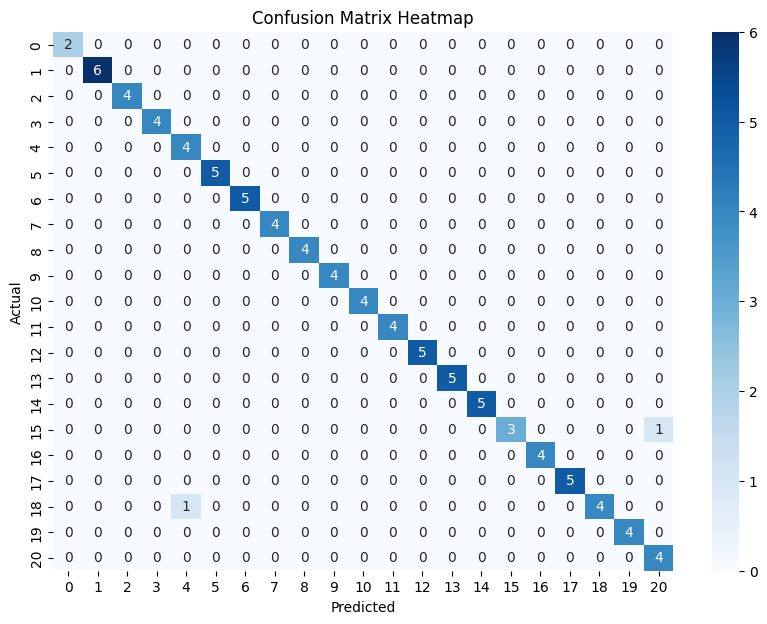

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()


Using Data Augmentation

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size = 0.2
stride = 5

# Initialize lists to store features (X) and labels (Y)
X_pose_train, X_pose_test = [], []
X_GEI_train, X_GEI_test = [], []
Y_train, Y_test = [], []

# Iterate over each class in the filtered_pose_dict and filtered_vid_dict
for class_label in filtered_pose_dict:
    pose_array = filtered_pose_dict[class_label]
    vid_array = filtered_vid_dict[class_label]
    total_length = pose_array.shape[0]
    test_length = int(test_size * total_length)

    # Generate a random start index for the test slice
    test_start_idx = np.random.randint(0, total_length - test_length + 1)

    # Extract the test slice
    test_slice = pose_array[test_start_idx:test_start_idx + test_length]
    test_vid_slice = vid_array[test_start_idx:test_start_idx + test_length]

    # The remaining part of the array is for training
    train_slice = np.concatenate((pose_array[:test_start_idx], pose_array[test_start_idx + test_length:]), axis=0)
    train_vid_slice = np.concatenate((vid_array[:test_start_idx], vid_array[test_start_idx + test_length:]), axis=0)

    # Apply sliding window to the training slice
    num_train_slices = (train_slice.shape[0] - 22) // stride
    for i in range(0, num_train_slices * stride, stride):
        pose_slice_23 = train_slice[i:i + 23, :, :]
        GEI_slice = train_vid_slice[i:i + 23, :, :].mean(axis=0, keepdims=True)
        X_pose_train.append(pose_slice_23)
        X_GEI_train.append(GEI_slice)
        Y_train.append(class_label)

    # Apply sliding window to the test slice
    num_test_slices = (test_slice.shape[0] - 22) // stride
    for i in range(0, num_test_slices * stride, stride):
        pose_slice_23 = test_slice[i:i + 23, :, :]
        GEI_slice = test_vid_slice[i:i + 23, :, :].mean(axis=0, keepdims=True)
        X_pose_test.append(pose_slice_23)
        X_GEI_test.append(GEI_slice)
        Y_test.append(class_label)

# Convert X and Y lists to NumPy arrays for further processing
X_pose_train = np.array(X_pose_train)
X_GEI_train = np.array(X_GEI_train)
X_pose_test = np.array(X_pose_test)
X_GEI_test = np.array(X_GEI_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Output the shapes of the training and testing sets to verify
print(f'Training Pose Features Shape: {X_pose_train.shape}')
print(f'Training GEI Features Shape: {X_GEI_train.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Pose Features Shape: {X_pose_test.shape}')
print(f'Testing GEI Features Shape: {X_GEI_test.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Pose Features Shape: (1604, 23, 25, 3)
Training GEI Features Shape: (1604, 1, 500, 500)
Training Labels Shape: (1604,)
Testing Pose Features Shape: (322, 23, 25, 3)
Testing GEI Features Shape: (322, 1, 500, 500)
Testing Labels Shape: (322,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le_ = LabelEncoder()
le_.fit(Y_train)
transformed_y = le_.transform(Y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_Pose = RandomForestClassifier(n_estimators = 100)
model_Pose.fit(X_pose_train.reshape(X_pose_train.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_GEI = RandomForestClassifier(n_estimators = 100)
model_GEI.fit(X_GEI_train.reshape(X_GEI_train.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_Pose.predict(X_pose_test.reshape(X_pose_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.92      1.00      0.96        24
           2       1.00      0.62      0.76        13
           3       1.00      1.00      1.00        16
           4       0.94      1.00      0.97        16
           5       0.76      1.00      0.86        16
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        15
           9       1.00      0.75      0.86        12
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        20
          13       0.84      0.94      0.89        17
          14       1.00      1.00      1.00        16
          15       0.80      1.00      0.89        16
          16       1.00      1.00      1.00        14
          17       1.00    

In [ ]:
y_pred = model_GEI.predict(X_GEI_test.reshape(X_GEI_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00        24
           2       0.93      1.00      0.96        13
           3       1.00      0.94      0.97        16
           4       0.76      1.00      0.86        16
           5       0.93      0.81      0.87        16
           6       0.71      1.00      0.83        17
           7       1.00      0.81      0.90        16
           8       1.00      1.00      1.00        15
           9       1.00      0.92      0.96        12
          10       0.90      0.64      0.75        14
          11       0.92      0.79      0.85        14
          12       1.00      1.00      1.00        20
          13       0.89      0.47      0.62        17
          14       0.93      0.88      0.90        16
          15       0.89      1.00      0.94        16
          16       0.74      1.00      0.85        14
          17       0.95    

In [ ]:
weights = [1,1]
pred1 = model_Pose.predict_proba(X_pose_test.reshape(X_pose_test.shape[0],-1))
pred2 = model_GEI.predict_proba(X_GEI_test.reshape(X_GEI_test.shape[0],-1))
pred_avg = np.average(np.asarray([pred1,pred2]), axis=0, weights=weights)
y_pred = np.argmax(pred_avg, axis=1)
y_pred = le_.inverse_transform(y_pred)

In [ ]:
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        24
           2       1.00      0.77      0.87        13
           3       1.00      1.00      1.00        16
           4       0.89      1.00      0.94        16
           5       0.80      1.00      0.89        16
           6       1.00      1.00      1.00        17
           7       1.00      0.94      0.97        16
           8       1.00      1.00      1.00        15
           9       1.00      0.92      0.96        12
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        16
          15       0.89      1.00      0.94        16
          16       1.00      1.00      1.00        14
          17       1.00    

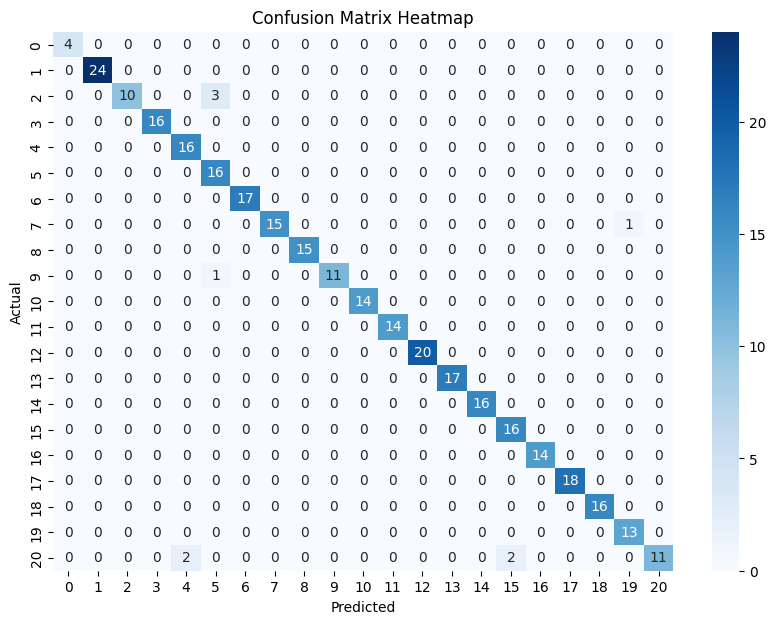

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()
